# Keras Implementation of Conditional GAN Model to Generate CIFAR10 images (3-channels [RGB] images)

Link to the Youtube tutorial video: https://www.youtube.com/watch?v=MAMSh5kVoec&list=PLZsOBAyNTZwboR4_xj-n3K6XBTweC4YVD&index=5

1) **Information of Conditional GAN model:**
    1) Conditional GAN model is basically a GAN model with an extra modality (EG: class label/image/...) that specifies (determines) the type of data the GAN model generates. 
    2) <img src="hidden\photo8.png" alt="This image is a representation of the simple neural network" style="width: 500px;"/>  <br />
    3) <img src="hidden\photo3.png" alt="This image is a representation of the simple neural network" style="width: 500px;"/>  <br />
    4) <img src="hidden\photo4.png" alt="This image is a representation of the simple neural network" style="width: 500px;"/>  <br />
    5) <img src="hidden\photo5.png" alt="This image is a representation of the simple neural network" style="width: 500px;"/>  <br />
    6) <img src="hidden\photo6.png" alt="This image is a representation of the simple neural network" style="width: 500px;"/>  <br />
    7) <img src="hidden\photo7.png" alt="This image is a representation of the simple neural network" style="width: 500px;"/>  <br />


In [11]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import adam_v2
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from matplotlib import pyplot as plt

# Load the dataset

Usually, the smaller the dimension of an image, the easier we can identify the class of the object appears in that image.

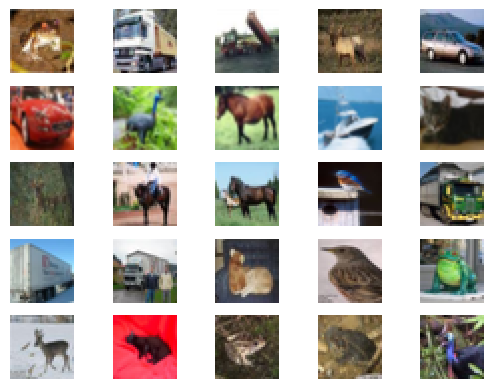

In [12]:
# Load the CIFAR10 dataset, then plot the first 25 samples of the dataset to get a quick understanding
# CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

(trainX, trainy), (testX, testy) = load_data()

# Plot the first 25 samples of the dataset as a subplot
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

# Define the function to create/build/define and compile the discriminator network

1) We use functional way of defining model as we have multiple inputs; both images and corresponding labels.
2) When we perform convolution operation on an image, we are reducing the image dimension (dowmsampling).
3) Given an input image (feature of image) and an input label (class of image), the Discriminator(discriminator network) outputs the likelihood(probability) of the image being real.
4) Unlike the unconditional (regular) GAN model, here we are also providing number of classes (CIFAR10 class) as input to the discriminator network. Hence, Input to the discriminator model will be both images and labels. 
5) in_label = Input(shape=(1,)) means we initialize the variable in_label as the input layer of the model. This input layer accepts each input sample that has size of 1 (a single value), but the batch size of the input layer is omitted (means you can supply as many samples as you want as the input, but each sample must have shape of 1). Hence, basically, when we define layers (structure) of a model, we only consider the size/dimension of a sample without considering the batch size (when the batch size argument is omitted) [means we think of if a sample of dimension x is provided to a layer as input, then the corresponding output becomes what dimension, then we assume a batch of samples at that stage have the same dimension as we described earlier]
6) model = Model([in_image, in_label], out_layer) # Here we just define like the model created using Model() has 2 input layers (in_image layer that accepts each input sample of dimension in_shape & in_label layer that accepts each input sample of dimension (1,1)) and 1 output layer (out_layer layer that provide each output sample of dimension (1,1)). We only consider a sample and omit the batch size here (because the batch size argument is omitted when we define both input layers). However, when deploying the model, we can provide a batch size of samples to both of the input layers, and the same batch size of samples will be generated at the output layer, while the dimension of each sample in the batch at different layers follows the ones we set during developing the layers of the model. When we want to deploy the model to make prediction, we just replace the name of the input layer with the variable names that store the training data (features). When we want to deploy the model for training, we just replace the name of the input layer with the variable names that store the training data (features) + the variable name that stores the ground truths.
    1) Reference: https://keras.io/guides/functional_api/

7) **Important information when defining the layers (structure) of a model:**
    1) When defining the layers (structure) of a model, we only consider the shape of each sample provided at the input layer, before and after each layer, and generated at the output layer but omit the batch size (if the batch size argument is omitted when we define the input layers). Means all about the shape of each sample at a particular layer. 
    2) However, when deploying the model, we can provide a batch size of samples to the input layer, and the same batch size of samples will be generated at the output layer. While the dimension of each sample in the batch at different layers follows the ones we set during developing the layers of the model.
    3) <img src="hidden\photo1.png" alt="This image is a representation of the simple neural network" style="width: 400px;"/>  <br />
        1) Reference: https://keras.io/guides/functional_api/
        

In [13]:
# Define the standalone discriminator model
# Given an input image, the Discriminator(discriminator network) outputs the likelihood(probability) of the image being real.
# Hence, the discriminator network is a binary classifier that performs binary classification - true or false (1[real image] or 0[fake image]). So using sigmoid activation at the output layer.

# Unlike the unconditional (regular) GAN model, here we are also providing number of classes (labels) as input. 
# Hence, Input to the model will be both images and labels.
# 
# Important information when defining the layers (structure) of a model:
# 1) We only consider the shape of a sample provided at the input layer, before and after each layer, and generated at the output layer but omit the batch size (if the batch size argument is omitted when we define the input layers). Means all about the shape of each sample at a particular layer.
# 2) However, when deploying the model, we can provide a batch size of samples to the input layer, and the same batch size of samples will be generated at the output layer. While the dimension of each sample in the batch at different layers follows the ones we set during developing the layers of the model.
#
def define_discriminator(in_shape=(32,32,3), n_classes=10):
	
    # Input 1: Label input
	in_label = Input(shape=(1,)) # This line initializes the variable in_label as the input layer of the model. Each sample provided to this input layer must have size of 1 (a single value), but the batch size of this input layer is omitted (means you can supply any batch size of samples as you want to this input layer as the input, but each sample must have shape of 1).
	# Embedding for categorical input
    # Each label (total 10 classes for CIFAR10 dataset), will be represented by a vector of size 50. 
    # This vector of size 50 will be learnt by the discriminator network
	li = Embedding(n_classes, 50)(in_label) # the variable "n_classes" refers to the vocabulary size (the range of positive integers the embedding layer can identify and convert each of them into a vector of fixed size). "Embedding(n_classes, 50)(in_label)" means the embedding layer is linked to the in_label layer (means the in_label layer is the input of the embedding layer). The embedding layer will convert each sample (in the range from 0 to [n_classes-1]) in the variable in_label into a vector of size 50.
	# Upsampling (scale up) each label vector sample to the dimension of an image sample, using linear activation
	n_nodes = in_shape[0] * in_shape[1] # the numbers of neurons in the Dense layer for upsampling each label vector sample to the dimension of an image sample is 32x32 = 1024. 
	li = Dense(n_nodes)(li) # Means each input label vector sample of this Dense layer (li) has shape of (1,50), each output label vector sample of this Dense layer (li) has shape of (1,1024) [1D, a string of numbers].
	# Reshape each label vector sample to an additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li) # Means each input label vector sample of this Reshape layer (li) has shape of (1,1024) [1D, a string of numbers], each output label vector sample of this Reshape layer (li) has shape of (32,32,1) [2D], the '1' means the label information takes a channel.
    
    
	# Input 2: Image input
	in_image = Input(shape=in_shape) # This line initializes the variable in_shape as the input layer of the model. Each sample provided to this input layer must have size of in_shape=(32,32,3) [because we are using CIFAR10 dataset]. But the batch size of this input layer is omitted (means you can supply any batch size of samples as you want to this input layer as the input, but each sample must have shape of in_shape=(32,32,3)).
	# Concatenate label as a channel
	merge = Concatenate()([in_image, li]) # After concatenating each sample in in_image (image of dimension (32,32,3)) with the corresponding sample in li (its corresponding label information of dimension (32,32,1)), the output sample (image) has dimension of (32,32,4) [Now each image has 4 channels, 3 channels for image and the another 1 channel for label). Each output (concatenated) sample (imaged) is stored in the variable merge.
    
	# Downsample: This part is same as unconditional (regular) GAN model up to the output layer.
    # Here, the discriminator network receives each combined input/image (input image + input label) to classify if each of the received image is a real image.
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) # Means each input sample of this convolution layer (merge) has shape of (32,32,4), each output sample of this convolution layer (fe) has shape of (16,16,128). So downsampling is performed here [from 32x32 reduced to 16x16].
	fe = LeakyReLU(alpha=0.2)(fe)
	# Downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) # Means each input sample of this convolution layer (fe) has shape of (16,16,128), each output sample of this convolution layer (fe) has shape of (8,8,128). So downsampling is performed here [from 16x16 reduced to 8x8]. This output sample which has shape of (8,8,128) is treated as a feature map.
	fe = LeakyReLU(alpha=0.2)(fe)
	# Flatten each feature map (downsampled concatenated pixel values + label information of each image)
	fe = Flatten()(fe)  # Means each input sample of this flatten layer (fe) has shape of (8,8,128), each output sample of this flatten layer (fe) has shape of (8*8*128=8192,1) [1D, a string of numbers].
	# Dropout
	fe = Dropout(0.4)(fe)
	# Output layer of the discriminator network
	out_layer = Dense(1, activation='sigmoid')(fe)  # Means each input sample of this Dense layer (fe) has shape of (8192,1) [1D, a string of numbers], each output sample of this Dense layer (out_layer) has shape of (1,1) [1D, a value].
    
	# Create/Define the discriminator model
    # Combine input label with input image and supply as inputs to the discriminator model. 
	model = Model([in_image, in_label], out_layer) # Here we just define like the model created using Model() has 2 input layers (in_image layer that accepts each input sample of dimension in_shape & in_label layer that accepts each input sample of dimension (1,1)) and 1 output layer (out_layer layer that provide each output sample of dimension (1,1)). We omit the batch size here (because the batch size argument is omitted when we define both input layers). However, we can provide a batch size of samples to both of the input layers, and the same batch size of samples will be generated at the output layer, while the dimension of each sample in the batch at different layers follows the ones we set during developing the layers of the model. When we want to deploy the model to make prediction, we just replace the name of the input layer with the variable names that store the training data (features). When we want to deploy the model for training, we just replace the name of the input layer with the variable names that store the training data (features) + the variable name that stores the ground truths.
	# Compile the discriminator model
	opt = adam_v2.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model # Return the created & compiled discriminator network

# The 2 lines below just for the purpose of showing the summary of the discriminator network only.
test_discr = define_discriminator()
print(test_discr.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        500         input_9[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1, 1024)      52224       embedding_4[0][0]                
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
____________________________________________________________________________________________

# Define the function to create/build/define the generator network

1) Here we use Embedding layer to embed each label of single value into a vector of fixed size, Dense layer to find the relationship (weights and biases) between each image feature), and Conv2DTranspose layer to perform deconvolution/upsampling operation to build the generator network structure. But the generator network structure can be complicated based on your application. For example, you can use VGG for super resolution GAN.        
2) The generator network is not compiled as it is not directly trained like the discriminator. Generator is trained via GAN combined model. 
3) Given an input noise/latent vector and input label, the Generator(generator network) outputs an image (fake image) that has dimension of 32x32 pixels, with 3 channels.
4) **Important information when defining the layers (structure) of a model:**
    1) We only consider the shape of each sample provided at the input layer, before and after each layer, and generated at the output layer but omit the batch size (if the batch size argument is omitted when we define the input layers). Means all about the shape of each sample at a particular layer. 
    2) However, when deploying the model, we can provide a batch size of samples to the input layer, and the same batch size of samples will be generated at the output layer. While the dimension of each sample in the batch at different layers follows the ones we set during developing the layers of the model.

In [14]:
# Define the standalone generator model.
# Given inputs of noise/latent vector and label, the Generator (generator network) produces an image.(Here, the generator network produces an image having dimension 32x32 pixels as the output for each latent vector & label as the input).
# latent_dim (the size of a latent vector), for example, can be 100, 1D array of size 100 (means a 1D vector that having 100 elements/values) .

# Here we use Embedding layer to embed each label of single value into a vector of fixed size, Dense layer to find the relationship (weights and biases) between each image feature), and Conv2DTranspose layer to perform deconvolution/upsampling operation to build the generator network structure. But the generator network structure can be complicated based on your application. For example, you can use VGG for super resolution GAN.       
# 
# Important information when defining the layers (structure) of a model:
# 1) We only consider the shape of a sample provided at the input layer, before and after each layer, and generated at the output layer but omit the batch size (if the batch size argument is omitted when we define the input layers).  Means all about the shape of each sample at a particular layer.
# 2) However, when deploying the model, we can provide a batch size of samples to the input layer, and the same batch size of samples will be generated at the output layer. While the dimension of each sample in the batch at different layers follows the ones we set during developing the layers of the model.
#
def define_generator(latent_dim, n_classes=10):
    
	# Input 1: Label input
	in_label = Input(shape=(1,)) # This line initializes the variable in_label as the input layer of the model. Each sample provided to this input layer must have size of 1 (a single value), but the batch size of this input layer is omitted (means you can supply any batch size of samples as you want to this input layer as the input, but each sample must have shape of 1).
	# Embedding for categorical (label) input
    # Each label (total 10 classes for CIFAR10 dataset), will be represented by a vector of size 50. 
	li = Embedding(n_classes, 50)(in_label) # the variable "n_classes" refers to the vocabulary size (the range of positive integers the embedding layer can identify and convert each of them into a vector of fixed size). "Embedding(n_classes, 50)(in_label)" means the embedding layer is linked to the in_label layer (means the in_label layer is the input of the embedding layer). The embedding layer will convert each sample (in the range from 0 to [n_classes-1]) in the variable in_label into a vector of size 50.
    
	# Upsampling (scale up) each label vector sample to the dimension of a latent vector sample, using linear activation
	n_nodes = 8 * 8  # The numbers of neurons in the Dense layer for upsampling each label vector sample to the dimension of a latent vector sample is 8*8=64. This step is just to match the dimension of each label sample with the dimension of each latent vector sample for concatenation later.  
	li = Dense(n_nodes)(li) # Means each input label vector sample of this Dense layer (li) has shape of (1,50), each output label vector sample of this Dense layer (li) has shape of (1,64) [1D, a string of numbers].
	# Reshape each label vector sample to an additional channel
	li = Reshape((8, 8, 1))(li) # Means each input label vector sample of this Reshape layer (li) has shape of (1,64) [1D, a string of numbers], each output label vector sample of this Reshape layer (li) has shape of (8,8,1) [2D], the '1' means the label information takes a channel.
    
    
	# Input 2: Latent vector input
	in_lat = Input(shape=(latent_dim,)) # This line initializes the variable in_lat as the input layer of the model. Each sample provided to this input layer must have size of (latent_dim=100,1), but the batch size of this input layer is omitted (means you can supply any batch size of samples as you want to this input layer as the input, but each sample must have shape of (latent_dim=100,1)).
    
	# Foundation for 8x8 image:
    # We will reshape each input latent vector sample into a 8x8 image sample as a starting point. 
    # So n_nodes (number of neurons) for the Dense layer can be 128x8x8=8192. So when we reshape each output sample of the Dense layer above,
    # it would be an image sample of (8,8,128), and that image sample can be slowly upscaled to 32x32 image sample for output at the output layer of the generator network.
    # Note that this part is same as the unconditional (regular) GAN model until the output layer. 
    # While defining the model inputs, we will use both of the input layers of in_label and in_lat.
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat) # Means each input latent vector sample of this Dense layer (in_lat) has shape of (1,100), each output image sample features of this Dense layer (gen) has shape of (1,8192) [1D, a string of numbers].
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen) # Means each input image sample features of this Reshape layer (gen) has shape of (1,8192) [1D, a string of numbers], each output image sample of this Reshape layer (gen) has shape of (8, 8, 128) [2D].
	# Concatenate (Merge) each image sample in gen with each label sample in li, so that both of them now become a single input sample
	merge = Concatenate()([gen, li]) # After concatenating each image sample in gen of dimension (8,8,128) with its corresponding label sample of dimension (8,8,1), each output image sample has dimension of (8,8,129) [Now each output image has 129 channels, 128 channels for image in gen and the another 1 channel for label). Each output (concatenated) image sample is stored in the variable merge.
	# Upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) # Means each input sample of this deconvolution layer (merge) has shape of (8,8,129), each output sample of this deconvolution layer (gen) has shape of (16,16,128). So upsampling is performed here [from 8x8 reduced to 16x16].
	gen = LeakyReLU(alpha=0.2)(gen)
	# Upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) # Means each input sample of this deconvolution layer (gen) has shape of (16,16,128), each output sample of this deconvolution layer (gen) has shape of (32,32,128). So upsampling is performed here [from 16x16 reduced to 32x32].
	gen = LeakyReLU(alpha=0.2)(gen)
	# Output layer of the generator network
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) # Means each input sample of this convolution layer (gen) has shape of (32,32,128), each output sample of this convolution layer (out_layer) has shape of (32,32,3). 
	# Create/Define the generator model
	model = Model([in_lat, in_label], out_layer) # Here we just define like the model created using Model() has 2 input layers (in_lat layer that accepts each input sample of dimension (latent_dim=100,1) & in_label layer that accepts each input sample of dimension (1,1)) and 1 output layer (out_layer layer that provide each output sample of dimension (32,32,3)). We omit the batch size here (because the batch size argument is omitted when we define both input layers). However, when we want to deploy the model, we can provide any batch size of samples to both of the input layers, and the same batch size of samples will be generated at the output layer, while the dimension of each sample in the batch at different layers follows the ones we set during developing the layers of the model. When we want to deploy the model to make prediction, we just replace the name of the input layer with the variable names that store the training data (features). When we want to deploy the model for training, we just replace the name of the input layer with the variable names that store the training data (features) + the variable name that stores the ground truths.
	return model   # Return the created generator network. The generator model is not compiled as it is not directly trained like the discriminator network (we train the generator network by using the GAN model [generator network + discriminator network]).

# The 2 lines below just for the purpose of showing the summary of the generator network only.
test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 8192)         827392      input_12[0][0]                   
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        500         input_11[0][0]                   
____________________________________________________________________________________________

# Define the function to create/build/define and compile the GAN model

In [15]:
# Generator network is trained via GAN combined model. 
# Define the GAN model (combined generator and discriminator model), for updating the weights and biases of the generator network
# Discriminator network is trained separately so here only generator network will be trained by keeping the weights and biases of the discriminator network constant. 
# 
# Important information when defining the layers (structure) of a model:
# 1) We only consider the shape of a sample provided at the input layer, before and after a layer, and generated at the output layer but omit the batch size (if the batch size argument is omitted when we define the input layers). 
# 2) However, when deploying the model, we can provide a batch size of samples to the input layer, and the same batch size of samples will be generated at the output layer. While the dimension of each sample in the batch at different layers follows the ones we set during developing the layers of the model.
#
def define_gan(g_model, d_model):
	d_model.trainable = False  # Discriminator network is trained separately. So its weights and biases are set to not trainable (hold constant).
    
    # Connect the generator network to the discriminator network...
	# First, by using created_model.input, get the shape of each sample of noise/latent vector and label, which are the inputs of the generator model
	gen_noise, gen_label = g_model.input  # The shape of each latent vector sample [which is (latent_dim=100,1) here] is stored in the variable gen_noise and the shape of each label sample [which is (1,1) = 1 (a single value) here] is stored in the variable gen_label 
	# Then, by using created_model.output, get the shape of each output sample of the generator model, then store in the variable gen_output
	gen_output = g_model.output  # The shape of each output sample of the generator model [which is 32x32x3 here] is stored in the variable gen_output
    
	# Each image generated by the generator network and its corresponding label are the inputs of the discriminator network
	gan_output = d_model([gen_output, gen_label]) # Define the created discriminator network as a layer of the model to provide real image probability score. Means by omitting the sample batch size (means you can provide any batch size of samples you want), the discriminator network will receive each sample of shape (32,32,3) at the input layer called gen_output & receive each sample of shape 1 at the input layer called gen_label. Then, the discriminator network generates each output sample of shape (1,1) [which is the real image classification probability score].
	# Create/Define the GAN model. The GAN model takes each latent vector sample (gen_noise) and each label sample (gen_label) as the inputs, then generates an output sample of shape (1,1) [which is the real image classification probability score]
	model = Model([gen_noise, gen_label], gan_output) # Here we just define like the model created using Model() has 2 input layers (gen_noise layer that accepts each input sample of dimension (latent_dim=100,1) & gen_label layer that accepts each input sample of dimension (1,1)) and 1 output layer (gan_output layer that provides each output sample of dimension (1,1)). We omit the batch size here (because the batch size argument is omitted when we define both input layers). However, when we want to deploy the model, we can provide any batch size of samples to both of the input layers, and the same batch size of samples will be generated at the output layer, while the dimension of each sample in the batch at different layers follows the ones we set during developing the layers of the model. When we want to deploy the model to make prediction, we just replace the name of the input layer with the variable names that store the training data (features). When we want to deploy the model for training, we just replace the name of the input layer with the variable names that store the training data (features) + the variable name that stores the ground truths.
	# Compile the GAN model
	opt = adam_v2.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model # Return the created & compiled GAN model



# Define the function to load images (real images) from the CIFAR10 dataset, then rescale the real images

Since the generator network output layer uses tanh activation function (tanh activation function provides an output value in the range from -1 to 1), we convert(rescale) each feature (pixel value) of each real image (from dataset) into the range from -1 to 1 to match the output of generator.

In [16]:
# Load CIFAR training images
def load_real_samples():
	(trainX, trainy), (_, _) = load_data() # we only load the features and CIFAR labels of the train set images of the dataset
	# Convert each feature (pixel value) of each real image (from dataset) into a float number
	X = trainX.astype('float32')
	# Scale each feature (pixel value) of each real image (from dataset) from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5 # Since the generator network output layer uses tanh activation function (tanh activation function provides an output value in the range from -1 to 1), we convert(rescale) each feature (pixel value) of each real image (from dataset) into the range from -1 to 1 to match the output of generator.
	return [X, trainy] # Return the scaled features and CIFAR labels of the train set images of the dataset

# Define a function to select a half batch size of real images (features + labels) from the dataset, then assign each selected real image a value of 1 as ground truth

In [17]:
# Pick a batch of random real samples to train the GAN model
# In fact, we will train the GAN model on a half batch of real images and another half batch of fake images. 
# For each real image we assign a label 1 as ground truth and for fake we assign label 0 as ground truth. 
def generate_real_samples(dataset, n_samples): # The variable dataset contains the real images (the feature of real images), the variable n_samples refer to the half batch size 
	# Split the loaded real images features and CIFAR labels into the variable images and variable labels respectively
	images, labels = dataset  
	# Select half batch size numbers of real images randomly
	ix = randint(0, images.shape[0], n_samples) # Select n_samples numbers of real images, by randomly generating n_samples numbers of integers between the range from 0 (low, inclusive) to images.shape[0] (high, exclusive). Each randomly generated interger by the function represents the index of the real image features in the variable image and the index of the corresponding real image labels in the variable labels. The randomly generated indices are stored in the variable ix. Since each integer is randomly generated between the given range, it is possible to have multiple same integer (index of an real image/sample) in ix, so that it is possible to use multiple same real images for training.
	# Load the features and labels of randomly chosen real images into variables X and labels respectively
	X, labels = images[ix], labels[ix]
	# Generate class label (ground truth) for each chosen real image and assign to the variable y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  # Label=1 indicating they are real
	return [X, labels], y # Returns the features and CIFAR labels of the randomly selected real images, and also their ground truths of 1.


# Define a function to generate half batch size of random noise/latent vector as the input of the generator network

In [18]:
# Generate n_samples number of latent vectors as input for the generator network
def generate_latent_points(latent_dim, n_samples, n_classes=10): # the variable latent_dim refers to the dimension(feature size) of the latent vector, the variable n_samples refers to the half batch size, the variable n_classes refers to the number of class in the dataset.
	# Generate points (latent vector) in the latent space. The numpy.random.randn() function creates an array of specified shape and fills it with random values as per standard normal distribution. 
	x_input = randn(latent_dim * n_samples)
	# Reshape into a batch of inputs, in the shape of (n_samples, latent_dim), for the generator network
	z_input = x_input.reshape(n_samples, latent_dim) # the reshape() reshapes the (latent_dim * n_samples) numbers of random values in 1D stored in the variable x_input into an array that having dimension of (n_samples, latent_dim) as output. Means the output array has a dimension of n_samples of rows and latent_dim of columns.
	# Randomly generate CIFAR class labels (0 to 9) to each latent vector, by randomly generating n_samples numbers of integers between the range from 0 (low, inclusive) to n_classes (high, exclusive). Since each integer is randomly generated between the given range, it is possible to have multiple same integer (label) in labels, so that it is possible to use multiple same labels for training.
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels] # Returns a group (half batch size) of latent vector samples and their corresponding randomly generated CIFAR class labels

# Define a function to generate images (fake images) using half batch size of random noise/latent vector

In [19]:
# Use the generator to generate n_samples fake examples, with class labels (ground truths)
# Supply the generator network with latent_dim and n_samples (number of samples=half batch size) as input.
# Use the above generate_latent_points() to generate latent points (latent vector, because a vector is a point in a vector space). 
def generate_fake_samples(generator, latent_dim, n_samples): # the variable generator is the generator network, the variable latent_dim refers to the dimension(feature size) of the latent vector, the variable n_samples refers to the half batch size 
	# Generate points (latent vector) in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples) # generate_latent_points() returns a group (half batch size) of latent vector samples to variable z_input and their corresponding CIFAR class labels to variable labels_input
	# Predict using generator network to generate fake samples. 
	images = generator.predict([z_input, labels_input]) # Deploy the created generator network here to provide image (fake image). The generator network receive z_input & labels_input as inputs. Then, the generator network generates images (fake images) as the output. The number of images generated same as the number of samples (batch size) of z_input and labels_input.
	# Class labels will be 0 as these samples(images) are fake.
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y # Returns a group (half batch size) of fake images, their corresponding CIFAR class labels (values 0 to 9), and their corresponding labels (values of 0)

# Define the function to perform the GAN model training

1) **GAN Model training procedure:**
    1) Set the humber of epochs for training, the batch size (the number of images involved in the training at each epoch), the epoch interval to save the images generated by the generator network (the saved images are generated for visualization purpose only, not involved in the training)
    2) For each  epoch:
        1) Part 1: Train Discriminator (Use the discriminator network only)
            1) Use the real and fake (generated) images separately to train the discriminator network to only recognize real images as real images (not fooled by the fake images). At each epoch, we randomly select half batch numbers of the real images from the dataset & generate half batch numbers of random noise/latent vector, before the discriminator network training is started.
            2) The discriminator network accepts real and fake (generated) images as the input, and
            3) provides the probability scores of the given images being the real images as the output
            4) Calculate the cost function value (the total loss of each epoch), then use the cost function value to learn (update) the parameters (weights and biases) of the discriminator network only that allows the discriminator network to only recognize real images as real images (not fooled by the fake images)
        2) Part 2: Train Generator (Use the GAN model [generator network + discriminator network])
            1) Use the real and fake (generated) images separately to train the discriminator network to only recognize real images as real images (not fooled by the fake images)
            2) The GAN model accepts a batch (group) of randomly generated noise vectors as the input (actually it is the generator network accepts the randomly generated noise vectors as the input)
            3) The generator network generates a batch of images (fake images) as its output (For each noise vector, the generator network generates 1 image (fake image))
            4) The discriminator network then accepts that batch of images (fake images) generated by the generator network as its input. At the same time, the discriminator network is set to not trainable (so the weights and biases of the discriminator network will not be affected by the cost function value of this epoch at this stage)
            5) The discriminator network then provides the probability scores of the given images being the real images as the output (as the output of the GAN model)
            6) Calculate the cost function value (the total loss of each epoch), then use the cost function value to learn (update) the parameters (weights and biases) of the generator network only. So when more and more epochs are conducted, the generator network becomes more capable to generate fake images that are similar to the real images recognized by the discriminator network [at least causing the discriminator network to recognize the fake images as real images at high probability]
    
       
2) **VERY IMPORTANT UNDERSTANDING OF GAN TRAINING CONCEPT:**
    1) At each epoch of training (especially at the 1st epoch), the key is to train the discriminator network to recognize real images using the real images first. 
    2) After the discriminator network is completely trained to recognize real images using the real images, the discriminator network is trained to recognize the real images using the fake images. This is because after the discriminator network has been trained to recognize the real images using the real images to some extent (at this moment, the discriminator network knows nothing exists in its world except the real images, and its learned weights and biases can tell if a given image is a real image (at this stage, when the discriminator network is provided with real images, it provides the probability scores of the given images being the real images > 0.5)), when the discriminator network is trained to recognize the real images with the fake images, the discriminator network can tell the given fake images are not real images (provide the probability scores of the given images being the real images < 0.5). 
    3) Since we assume the ground truth of a real image is a value of 1, when the discriminator network is firstly trained to recognize the real images with real images (remember that the definition of neural network training is to update the neural network's weights so that the training loss reduces), the discriminator network will provide the probability score of the given image being a real image > 0.5. So now when we want to keep training the discriminator network to recognize the real images, we can train the discriminator network to recognize the real images by using the fake images and assume the ground truth of a fake image (adversarial to real image) is a value of 0 (adversarial to 1). 
    4) Since before this the discriminator network already trained to recognize the real images using the real images to some extent, when it is given with the fake images in the training, its learned weights and biases will produce probability score of the given image being a real image < 0.5 (adversarial to > 0.5). 
    5) Since the learning of a neural network is related to the gradient descent (which is also related to the partial derivative of the cost function with respect to each weight and bias), the cost function must be kept as small as possible (no matter the discriminator network is trained to recognize real images with real images or fake images) so that the discriminator network training will keep proceed in the same direction (to recognize real images better and better). 
    6) Hence: 
        1) The ground truth of a real image is assumed as a value of 1 + the probabilty score provided by the discriminator network for a real image is closer to 1 makes the cost function value tends to be smaller in the training with real images; 
        2) The ground truth of a fake image is assumed as a value of 0 + the probabilty score provided by the discriminator network for a fake image is closer to 0 makes the cost function value tends to be smaller in the training with fake images. 
    7) And that's why the discriminator network is trained in the same direction (to recognize the real images better and better) when its trainings are involving real images and fake images separately. 
    8) Since now the discriminator network has been trained with the ability to tell a given fake image is not a real image (can differentiate), the generator network can proceed with its training (to learn the ability to generate fake images that are similar to the real images recognized by the discriminator network) by generating fake images and see if the discriminator network will be fooled (recognize the fake images as the real images). 
    9) Since in the generator network training, the ground truth takes the ground truth of real image (value of 1). So at each epoch, the many the generated (fake) images can fool the discriminator network, the many times the discriminator network will provide probability score closer to 1 in that epoch, and causing the cost function value of that epoch tends to become smaller. 
    10) Remember that (the definition of neural network training is to update the neural network's weights so that the training loss reduces) + (the discriminator network will provide the probability score of the given image being a real image > 0.5 [even if it is fooled by a fake image] and causes the cost function value to tend to be smaller), so actually the generator network is also trained in the same direction as the discriminator network (to learn the ability [weights and biases] to generate fake images that are similar to the real images recognized by the discriminator network [at least causing the discriminator network to recognize the fake images as real images at high probability]). 
    11) In summary, the discriminator network can be treated as a level/challenge for the generator network. If we want to train a generator network to able to generate very realistic images (the data we want) well, we must first train the discriminator network to able to recognize the realistic images (the data we want) well.
    
    
3) **Information of train_on_batch():**
    1) According to Keras documentation, train_on_batch() runs a single gradient update on a single batch of data, then returns a scalar loss value. This means model.train_on_batch() runs the model training using the features and target (ground truth) of a batch of samples (images), followed by automatically calculating the loss of the training, then update the weights of the model, and finally return the calculated training loss in one-shot.
    2) According to StackExchange, model.train_on_batch() allows you to expressly update the weights of your model based on a collection of samples you provide, without regard to any fixed batch size. You could use model.train_on_batch() to directly update the weights of the existing model only on those samples you provide. 
        1) Reference: https://stackoverflow.com/questions/49100556/what-is-the-use-of-train-on-batch-in-keras
    3) We use model.train_on_batch() (not model.fit()) because model.train_on_batch() gives us more flexibility in training which model at a given time than model.fit(). But when we use model.train_on_batch() to perform model training, we need to have model.train_on_batch() nested within the epoch loop and batch loop (to imitate the ways the model.fit() performs model training)
        

In [20]:
# Train the discriminator network first, then only train the generator network at each epoch 
# At each epoch, we first select a random batch of images (real images) from our true/real dataset.
# Then, generating a set of images (fake images) using the generator network. 
# We then feed both set of real and fake images into the Discriminator (discriminator network), followed by starting its training. 


def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch) # Since by definition, an epoch is considered completed only if all train set samples have been fed into a model for training. dataset.shape[0] refers to the number of samples/images involved in each epoch of training. n_batch refers to the number of samples(images) available in each subbatch (subgroup) involved in each epoch of training. bat_per_epo refers to the number of samples/images subbatches involved in each epoch of training (If samples/images in all subbatches [equivalent to all train set samples] have been fed into a model for training, an epoch is considered completed). 
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
		
		# ---------------------
        #  Part 1) Train Discriminator (Use the discriminator network only)
        #  a) Use the real and fake (generated) images separately to train the discriminator network to only recognize real images as real images (not fooled by the fake images)
        #  b) The discriminator network accepts real and fake (generated) images as the input, and
        #  c) provides the probability scores of the given images being the real images as the output
        #  d) Calculate the cost function value (the total loss of each epoch), then use the cost function value to learn (update) the parameters (weights and biases) of the discriminator network only that allows the discriminator network to only recognize real images as real images (not fooled by the fake images)
        # ---------------------

            # Train the discriminator (by using the discriminator network only) on real and fake images, separately (half batch each). Research showed that separate training is more effective. 
			# Get randomly selected 'real' samples (images) and their ground truth labels (values of 1)
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch) # X_real stores the features of the randomly selected real images, labels_real stores their corresponding CIFAR labels (values 0 to 9 ), and their corresponding ground truth labels (values of 1 as real image)
			# Update discriminator model weights automatically (do by train_on_batch()) based on d_loss_real
            # train_on_batch() allows you to update weights based on a collection of samples you provide.
            # Let us just capture loss (d_loss_real) and ignore accuracy value (2nd output represented by '_' below)
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			# Get 'fake' samples (images) and their ground truth labels (values of 0 as fake images)
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch) # X_fake stores the randomly generated features of fake images, their corresponding randomly generated CIFAR class labels (values 0 to 9), and their corresponding ground truth labels (values of 0 as fake images)
			# Update discriminator model weights automatically (do by train_on_batch()) based on d_loss_fake
			# Let us just capture loss (d_loss_fake) and ignore accuracy value (2nd output represented by '_' below)
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            

            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Average loss if you want to report single..
            
			# Prepare points (latent vectors) in latent space as input for the generator network (for the generator network training purpose)
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch) # z_input stores a group (half batch size) of latent vector samples, labels_input stores their corresponding randomly generated CIFAR class labels
			
            
            # The generator network wants the discriminator network to label the generated samples (fake images) as valid (ones)
        	# This is where the generator network is trying to trick/fool the discriminator network into believing the generated (fake) image is true (hence value of 1 for y)			
			y_gan = ones((n_batch, 1)) # Create the inverted ground truth labels for the fake samples
            
			# Generator network is part of the combined model (GAN model) where it got directly linked with the discriminator network.
			# Train the generator network (by using the GAN model) with latent vector samples (z_input) and their corresponding randomly generated CIFAR class labels as features, and their corresponding inverted ground truth labels (values of 1). 
			# Again, 1 as the output as it is adversarial and if generator did a great job of folling the discriminator network then the output would be 1 (true)
			# Update generator model weights only (discriminator model weights are not updated) automatically (do by train_on_batch()) based on g_loss
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			
			# Print the losses on this batch at this epoch
			print('Epoch>%d; Batch>%d/%d; Discriminator_loss_on_real_data=%.3f; Discriminator_loss_on_fake_data=%.3f; Generator_loss=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	
	# save the generator model (Means after the training is completed, save the weights and biases of the generator network into a file, so that we can directly use this generator network for other applications later)
	g_model.save('cifar_conditional_generator_%dEpochs.h5' % n_epochs)



# Train the Conditional GAN model

In [21]:
# Size of the latent space (shape of each latent vector sample)
latent_dim = 100 # We set the latent_dim so that later we can build a generator network with latent_dim as input
# Create the discriminator network
d_model = define_discriminator() # We create the discriminator network by calling the function, so that we can call the discriminator network and use it with train_on_batch() for training later.
# Create the generator network
g_model = define_generator(latent_dim) # We create the generator network by calling the function, so that we can call the generator network and use it with train_on_batch() for training later.
# Create the GAN model (Here, it is the conditional GAN model)
gan_model = define_gan(g_model, d_model) # We create the GAN model by calling the function, so that we can call the GAN model and use it with train_on_batch() for training later.
# Load the real images from the dataset
dataset = load_real_samples()
# Train the GAN model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2)
    # g_model refers to the built generator network
    # d_model refers to the built discriminator network
    # gan_model refers to the built GAN model (generator network + discriminator network) [Here, it is the conditional GAN model]
    # dataset refers to the real images from the dataset
    # latent_dim refers to the size of each latent vector
    # n_epochs refers to the number of epochs for the GAN model training

Epoch>1; Batch>1/390; Discriminator_loss_on_real_data=0.696; Discriminator_loss_on_fake_data=0.697; Generator_loss=0.689
Epoch>1; Batch>2/390; Discriminator_loss_on_real_data=0.625; Discriminator_loss_on_fake_data=0.707; Generator_loss=0.679
Epoch>1; Batch>3/390; Discriminator_loss_on_real_data=0.553; Discriminator_loss_on_fake_data=0.726; Generator_loss=0.662
Epoch>1; Batch>4/390; Discriminator_loss_on_real_data=0.516; Discriminator_loss_on_fake_data=0.756; Generator_loss=0.640
Epoch>1; Batch>5/390; Discriminator_loss_on_real_data=0.480; Discriminator_loss_on_fake_data=0.796; Generator_loss=0.613
Epoch>1; Batch>6/390; Discriminator_loss_on_real_data=0.433; Discriminator_loss_on_fake_data=0.835; Generator_loss=0.594
Epoch>1; Batch>7/390; Discriminator_loss_on_real_data=0.423; Discriminator_loss_on_fake_data=0.863; Generator_loss=0.593
Epoch>1; Batch>8/390; Discriminator_loss_on_real_data=0.404; Discriminator_loss_on_fake_data=0.854; Generator_loss=0.615
Epoch>1; Batch>9/390; Discrimina

# Deploy the trained generator network to generate images, by using the randomly generated latent vectors as input

1) **Explanation of the command "labels = asarray([x for _ in range(10) for x in range(10)])":**
    1) The outer loop "for _ in range(10)" repeat the inner loop "for x in range(10)" 10 iterations. At each outer loop iteration, the inner loop runs 10 iterations itself to create a list (row) of numbers from 0 to 9. Eventually, we have 10 rows of numbers from 0 to 9, where each column having the same number. Hence, the images of the same column shown on the subplot should have the same CIFAR10 class label.
    2) <img src="hidden\photo2.png" alt="This image is a representation of the simple neural network" style="width: 500px;"/>  <br />
    

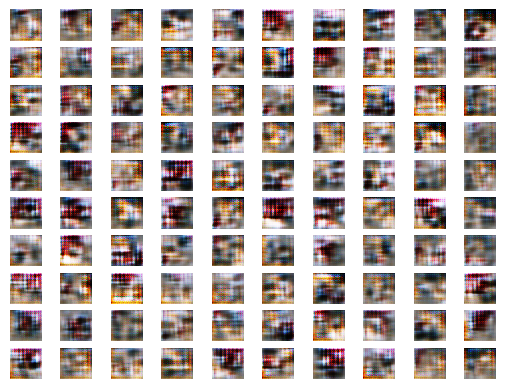

In [23]:
# Now, let us load the trained generator model and generate few images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

# Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

# Load the trained generator network
model = load_model('cifar_conditional_generator_2Epochs.h5')

# Generate multiple images:
# Randomly generate the latent vector samples and their corresponding CIFAR10 class labels
latent_points, labels = generate_latent_points(100, 100) # the argument 100 refers to generate 100 random latent vector samples and 100 random CIFAR10 label, so later the trained generator network can generate 100 images using them as input. Here, we only want the size of the variable labels, we will replace the samples in this variable labels with new samples (the specific CIFAR10 class labels we want) at next command.
# Generate the specific CIFAR10 class labels we want - generate 10 sets of CIFAR10 class labels, each set has CIFAR10 class label from 0 to 9.
labels = asarray([x for _ in range(10) for x in range(10)]) # The outer loop "for _ in range(10)" repeat the inner loop "for x in range(10)" 10 iterations. At each outer loop iteration, the inner loop runs 10 iterations itself to create a list (row) of numbers from 0 to 9. Eventually, we have 10 rows of numbers from 0 to 9, where each column having the same number. Hence, the images of the same column shown on the subplot should have the same CIFAR10 class label.
# Generate images using the trained generator network and the randomly generated latent vector samples and CIFAR10 class labels as inputs
X  = model.predict([latent_points, labels])

# The 2 commands below convert each pixel value of each generated image back to [0,255] (in case you want to save each generated image as JPEG or other format). Hence, these 2 commands below are optional.
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0 # Convert each pixel value of each generated image from [-1,1] to [0,1] 
X = (X*255).astype(np.uint8) # Convert each pixel value of each generated image from [0,1] to [0,255], then set each pixel value as an unsigned integer 8-bit type.

# Plot generated images stored in the variable examples as a subplot (grid) of size nxn
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
    
# Plot the result
show_plot(X, 10) # Show all the generated images as a subplot (grid) of 10x10


